In [1]:
## Import libraries

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import nltk 
import seaborn as sns
import datetime
import itertools

from nltk.tokenize import word_tokenize
from nltk import pos_tag, word_tokenize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics, model_selection, feature_selection
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors, linear_model, svm, tree
from sklearn.svm import SVC  
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

from numpy import loadtxt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import dask.dataframe as dd
 
pd.reset_option('precision')

In [2]:
## Read online marketing file

df_marketingdata = pd.read_csv('C:/Data/Online Retail.csv', dtype={'CustomerID':str})

## Change InvoiceDate to datetime 
df_marketingdata['InvoiceDate']= pd.to_datetime(df_marketingdata['InvoiceDate']) 


In [3]:
## View data information

df_marketingdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null object
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
## EXPLORATORY DATA ANALYSIS

In [6]:
## View the first few records to understand the data fields

df_marketingdata.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [7]:
# Produce summary statistics on numeric data

df_marketingdata[['Quantity','UnitPrice']].describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [8]:
# Determine the number of invoices

invoice_grp = df_marketingdata[['InvoiceNo']].groupby(['InvoiceNo'])
invoice_grp = invoice_grp['InvoiceNo'].count()

print('Number of invoices: ', len(invoice_grp))


Number of invoices:  25900


In [9]:
# Determine the number of customers

invoice_grp = df_marketingdata[['CustomerID']].groupby(['CustomerID'])
invoice_grp = invoice_grp['CustomerID'].count()

print('Number of Customer ID invoices: ', len(invoice_grp))

Number of Customer ID invoices:  4372


In [10]:
# List all invoices that contain a letter

df_marketingdata['invoice_type'] = df_marketingdata['InvoiceNo'].str.extract(r'(\D)')

df_filteredinvoice = df_marketingdata[df_marketingdata['invoice_type'].notnull()]

# Group all different types of indicators on the Invoice Number

filt_inv = df_filteredinvoice.groupby('invoice_type').size()

filt_inv

invoice_type
A       3
C    9288
dtype: int64

In [11]:
# View some of the data where the invoice contains a 'C' or 'D'

df_filteredinvoice.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,invoice_type
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom,C
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom,C
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom,C
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,C
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom,C


In [12]:
# Explore the records that contain an 'A'

df_marketingdata['invoice_type'] = df_marketingdata['InvoiceNo'].str.extract(r'(\D)')

df_filteredinvoice = df_marketingdata[df_marketingdata['invoice_type'].notnull()]

df_filteredinvoice.loc[df_filteredinvoice['invoice_type'].str.contains('A')]


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,invoice_type
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom,A
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom,A
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom,A


In [13]:
# Check for missing values

print('Variables with missing values \n\n ', df_marketingdata.isnull().sum())

Variables with missing values 

  InvoiceNo            0
StockCode            0
Description       1454
Quantity             0
InvoiceDate          0
UnitPrice            0
CustomerID      135080
Country              0
invoice_type    532618
dtype: int64


In [ ]:
## DATA CLEANSING

In [14]:
# Remove missing values from CustomerID

df_marketingdata.dropna(subset = ['CustomerID'],inplace=True)

print('Variables wiith missing values after removing CustomerID missing values \n\n', df_marketingdata.isnull().sum())

Variables wiith missing values after removing CustomerID missing values 

 InvoiceNo            0
StockCode            0
Description          0
Quantity             0
InvoiceDate          0
UnitPrice            0
CustomerID           0
Country              0
invoice_type    397924
dtype: int64


In [15]:
# View the data shape after missing records were removed 

df_marketingdata.shape

(406829, 9)

In [16]:
# Group the indicators on the Invoice Number

filt_inv = df_marketingdata.groupby('invoice_type').size()

filt_inv


invoice_type
C    8905
dtype: int64

In [17]:
# Calculate the percentage of cancelled records in the file to determine approach on how to handle these records

df_marketingdata['cancel record']= df_marketingdata['InvoiceNo'].str.startswith('C', 'A')

df_marketingdata.loc[df_marketingdata['cancel record'] == True].head()

num_cancel = df_marketingdata['cancel record'].sum()
num_records = df_marketingdata.shape[0]

# Produce the percentate of orders cancelled
total_percent = (num_cancel/num_records) * 100
print("Number of orders cancelled: ", num_cancel)
print("")
print("Percentage of orders cancelled: ", round(total_percent,2),'%')


Number of orders cancelled:  8905

Percentage of orders cancelled:  2.19 %


In [ ]:
# DATA CLEANING

In [18]:
# Remove the cancelled invoices that that do not have a previous invoice in the data 

# Create a tempoary dataframe to assess what records to remove and create a Amount Cancelled field to
# keep track of the amount of the invoice that was cancelled
df_mkdataclean = df_marketingdata.copy(deep = True)
df_mkdataclean['AmountCancelled'] = 0

remove_record = []

# Create a new dataframe df_mktest with a quantity of more than 0 or a Discount amount
for index, col in df_mkdataclean.iterrows():
    if (col['Quantity'] > 0) or col['Description']  == 'Discount': continue
    df_mktest = df_marketingdata[(df_marketingdata['CustomerID'] == col['CustomerID']) &
                               (df_marketingdata['StockCode'] == col['StockCode']) &
                               (df_marketingdata['InvoiceDate'] < col['InvoiceDate']) &
                               (df_marketingdata['Quantity'] > 0)].copy()
        
    # Identify the record index where there are no previous rows 
    if (df_mktest.shape[0] == 0):
        remove_record.append(index)
    
    # Identify records with a previous transaction
    elif (df_mktest.shape[0] == 1):
        index_order = df_mktest.index[0]
        df_mkdataclean.loc[index_order, 'AmountCancelled'] = -col['Quantity']
        remove_record.append(index)
   
     # Identify the record index where there are multple invoices associated with the customerid
    elif (df_mktest.shape[0] > 1):
        df_mktest.sort_index(axis=0, ascending=False, inplace=True)
        
        #Process through multiple invoices for the customerid
        for ind, val in df_mktest.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_mkdataclean.loc[ind, 'AmountCancelled'] = -col['Quantity']
            remove_record.append(index)
            break
            

print("Index of records to remove: {}".format(len(remove_record)))

Index of records to remove: 8772


In [19]:
# Remove records for that meet conditions

df_mkdataclean.drop(remove_record, axis=0, inplace=True)


In [20]:
# Remove columns no longer needed

df_mkdataclean.drop('invoice_type', axis = 1, inplace=True)
df_mkdataclean.drop('cancel record', axis = 1, inplace = True)

df_mkdataclean.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,AmountCancelled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0


In [ ]:
## ADDITIONAL EXPLORATORY DATA ANALYSIS AND DATA CLEANSING

In [21]:
# Produce summmary statistics after removal of cancelled records

df_mkdataclean[['Quantity','UnitPrice']].describe()

,Quantity,UnitPrice
count,398057.000000,398057.000000
mean,13.011466,3.129594
std,180.395290,22.320776
min,-720.000000,0.000000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,8142.750000


In [22]:
# Calculate a total price for each invoice and subtract the cancelled amount if one exists

df_mkdataclean['TotalPrice'] = df_mkdataclean['UnitPrice'] * (df_mkdataclean['Quantity'] - df_mkdataclean['AmountCancelled'])
df_mkdataclean.sort_values('CustomerID').head()[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,AmountCancelled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,74215,0.00
14945,537626,22774,RED DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland,0,15.00
428987,573511,23422,PANTRY HOOK BALLOON WHISK,12,2011-10-31 12:25:00,2.08,12347,Iceland,0,24.96
428988,573511,23420,PANTRY HOOK TEA STRAINER,12,2011-10-31 12:25:00,2.08,12347,Iceland,0,24.96
428989,573511,22699,ROSES REGENCY TEACUP AND SAUCER,18,2011-10-31 12:25:00,2.95,12347,Iceland,0,53.10


In [23]:
# Produce a df with the sum of invoice prices by customerid and invoiceno 
tip = df_mkdataclean.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
tot_inv_price = tip.rename(columns = {'TotalPrice':'Total Invoice Price'})

# Create another date field as int64 in order to average up the total price
df_mkdataclean['InvoiceDate_int64'] = df_mkdataclean['InvoiceDate'].astype('int64')

invdt_mean = df_mkdataclean.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int64'].mean()

# Add the InvoiceDate back to datetime format
df_mkdataclean['InvoiceDate_dt']=pd.to_datetime(df_mkdataclean['InvoiceDate_int64'])

# Drop fields no longer needed
df_mkdataclean.drop('InvoiceDate_int64', axis = 1, inplace = True)
#df_mkdataclean.drop('AmountCancelled', axis = 1, inplace = True)


print(len(tot_inv_price))


18636


In [24]:
# Group the transactions by CustomerID to get the total price of invoice
no_of_transactions = tot_inv_price.groupby(by=['CustomerID'])['Total Invoice Price'].sum()


In [26]:
# Explore the Customers, transactions and products purchased after cleaning dataframe

num_cust = df_mkdataclean[['CustomerID']].groupby(['CustomerID'])
num_cust = num_cust['CustomerID'].count()

num_prod = df_mkdataclean[['StockCode']].groupby(['StockCode'])
num_prod = num_prod['StockCode'].count()

num_inv = df_mkdataclean[['InvoiceNo']].groupby(['InvoiceNo'])
num_inv = num_inv['InvoiceNo'].count()

print('Number of Customers: ', len(num_cust))
print('Number of Products: ', len(num_prod))
print('Number of Transactions: ', len(num_inv))


Number of Customers:  4339
Number of Products:  3666
Number of Transactions:  18636


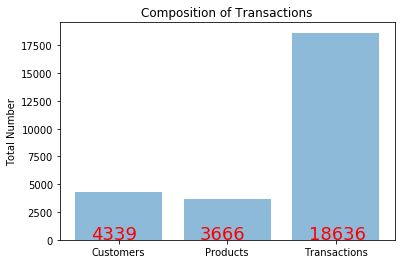

In [27]:
## Produce a bar graph of customers, products and transation overall counts
objects = ('Customers', 'Products', 'Transactions')
y_pos = np.arange(len(objects))
performance = [4339,3666,18636]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Total Number')
plt.title('Composition of Transactions')

for i, v in enumerate(performance):
    plt.text(i-.25, v/performance[i]+100, performance[i], fontsize=18, color='red')
plt.show()


In [28]:
## Calculate the total number of countries

total_cntry = df_mkdataclean[['Country']].count()
print('Total number of countries: ', total_cntry)

Total number of countries:  Country    398057
dtype: int64


In [29]:
## Explore where orders are initiated

cntry_grp = df_mkdataclean[['Country']].groupby(['Country'])
cntry_grp = cntry_grp['Country'].count()

print(cntry_grp.sort_values(ascending = False))

print()
print('Number of countries: ', len(cntry_grp))


Country
United Kingdom          354472
Germany                   9042
France                    8345
EIRE                      7239
Spain                     2485
Netherlands               2364
Belgium                   2031
Switzerland               1842
Portugal                  1462
Australia                 1185
Norway                    1072
Italy                      759
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     248
Unspecified                244
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         58
Lebanon                     45


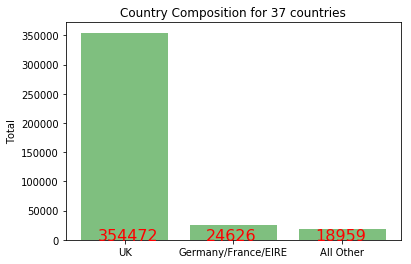

In [30]:
## Produce a bar graph of order counts in countries

objects = ('UK', 'Germany/France/EIRE', 'All Other')
y_pos = np.arange(len(objects))
performance = [354472,24626,18959]

plt.bar(y_pos, performance, align='center', alpha=0.5, color='green')
plt.xticks(y_pos, objects)
plt.ylabel('Total')
plt.title('Country Composition for 37 countries')
 
    
for i, v in enumerate(performance):
   plt.text(i-.25, v/performance[i]+100, performance[i], fontsize=16, color='red')

plt.show()

In [ ]:
## TEXT MINING OF DESCRIPTION FIELD

In [31]:
# Get the English stemmer to stem text in description field
stemmer = nltk.stem.SnowballStemmer("english")

# Put the description column in an array
df_description = df_mkdataclean['Description'].unique()
 
df_description

array(['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN',
       'CREAM CUPID HEARTS COAT HANGER', ...,
       'PINK CRYSTAL SKULL PHONE CHARM',
       'CREAM HANGING HEART T-LIGHT HOLDER',
       'PAPER CRAFT , LITTLE BIRDIE'], dtype=object)

In [32]:
# Use the snowball stemmer english version
stemmer = nltk.stem.SnowballStemmer("english")

#create a variable to check for nouns only
noun_id = lambda pos: pos[:2] == 'NN'

#initialize some dictionary values
stemmed_word_list=dict()
num_words=dict()
count_keywords  = dict()

for wd in df_description:
    #change to word to lower case
    word = wd.lower()
    
    #tokenize the word
    string_token = nltk.word_tokenize(word)
 
    #attach parts of speech to the words
    pt = pos_tag(string_token)

    #only return the nouns
    nouns = [word for (word, pt) in pt if noun_id(pt)] 
    
       
    for noun in nouns:
        stemmed_words = stemmer.stem(noun)
    
        # count up the words encountered 
        if stemmed_words in stemmed_word_list:
            stemmed_word_list[stemmed_words].add(noun)
            num_words[stemmed_words] += 1
        else:
            stemmed_word_list[stemmed_words] = {noun}
            num_words[stemmed_words] = 1


In [33]:
# Count the number of words

print(len(num_words))

1479


In [34]:
# Create a list of words in a list of key value pair and sort in descending value

product_list=[]
for key, val in num_words.items():
    product_list.append((key,val))

product_list.sort(key = lambda x:x[1], reverse = True)

plist = sorted(product_list, key = lambda x:x[1], reverse = True)

plist[:20]

[('heart', 267),
 ('vintag', 210),
 ('set', 206),
 ('pink', 188),
 ('bag', 164),
 ('box', 153),
 ('glass', 149),
 ('christma', 137),
 ('design', 128),
 ('candl', 121),
 ('holder', 120),
 ('flower', 120),
 ('decor', 108),
 ('metal', 99),
 ('retrospot', 90),
 ('card', 90),
 ('necklac', 85),
 ('paper', 84),
 ('blue', 80),
 ('art', 75)]

In [35]:
# Clean the list of words, removing insignificant words and words that occur less than 14 times

clean_plist=[]
for i in plist:
    if i[1] < 14 or len(i[0]) <= 3 or i[0] in ['pink', 'blue','ivori']: continue 
    clean_plist.append(i)

In [36]:
# Get the number of words left after more cleaning

print(len(clean_plist))

159


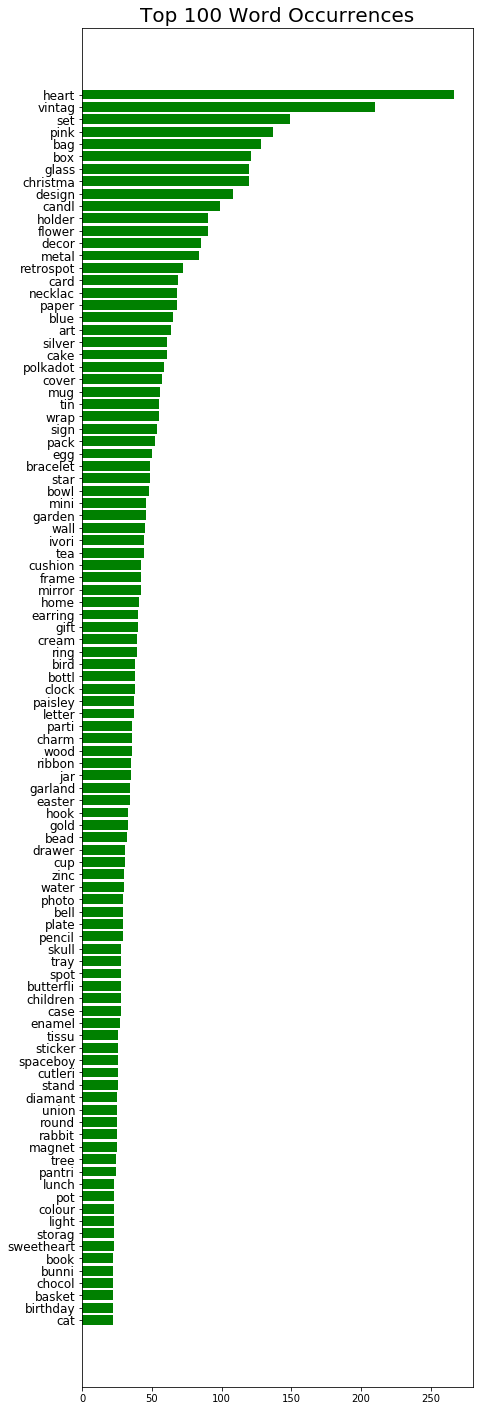

In [37]:
# Display the top 100 word occurences in a graphical form

fig, ax = plt.subplots(figsize=(7, 25))

#show first 100 words in list
ys = [i[1] for i in clean_plist[:100]]
xs = [k for k,i in enumerate(clean_plist[:100])]
xlbl = [i[0] for i in plist[:100]]

plt.yticks(xs, xlbl, fontsize = 12)

ax.barh(xs, ys, color = 'green', align = 'center')
ax = plt.gca().invert_yaxis()

plt.title("Top 100 Word Occurrences",fontsize = 20)
plt.show()


In [38]:
## CLUSTERING IDENTIFIED WORDS INTO CATEGORIES

In [39]:
# Get unique descriptions
plist_words = df_mkdataclean['Description'].unique()
print(plist_words[0:5])

['WHITE HANGING HEART T-LIGHT HOLDER' 'WHITE METAL LANTERN'
 'CREAM CUPID HEARTS COAT HANGER' 'KNITTED UNION FLAG HOT WATER BOTTLE'
 'RED WOOLLY HOTTIE WHITE HEART.']


In [42]:
# Create a matrix populating the existence of each work for all unique descriptions

#create a dataframe with the word occurences indicator (0 or 1)
df_word_list = pd.DataFrame()

#process through the description to determine if the word exists so it can be tagged with a 1 indicator
for key, occurence in clean_plist:
    df_word_list.loc[:,key] = list(map(lambda x:int(key.upper() in x), plist_words))
print(df_word_list[:10])

   heart  vintag  glass  christma  design  candl  holder  flower  decor  \
0      1       0      0         0       0      0       1       0      0   
1      0       0      0         0       0      0       0       0      0   
2      1       0      0         0       0      0       0       0      0   
3      0       0      0         0       0      0       0       0      0   
4      1       0      0         0       0      0       0       0      0   
5      0       0      0         0       0      0       0       0      0   
6      0       0      1         0       0      0       1       0      0   
7      0       0      0         0       0      0       0       0      0   
8      0       0      0         0       0      0       0       0      0   
9      0       0      0         0       0      0       0       0      0   

   metal  ...    green  pictur  wooden  piec  bathroom  girl  fruit  child  \
0      0  ...        0       0       0     0         0     0      0      0   
1      1  ...     

In [43]:
# Create bins and populate the average unit price into appropriate bins

unitbins = [0, 1, 2, 3, 5, 10]
bin_len = len(unitbins)

#create an empty list called bin_col
bin_col = []

#create the number of bin columns
for i in range(len(unitbins)):
    if i == len(unitbins)-1:
        col = '.>{}'.format(unitbins[i])
    else:
        col = '{}<.<{}'.format(unitbins[i],unitbins[i+1])
    bin_col.append(col)
    df_word_list.loc[:, col] = 0

#populate the appropriate bin where the average unit price exists
for i, prod in enumerate(plist_words):
    avgprc = df_mkdataclean[ df_mkdataclean['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while avgprc > unitbins[j]:
        j+=1
        if j == len(unitbins): break
    df_word_list.loc[i, bin_col[j-1]] = 1

#check the number of records in each bin
for i in range(len(unitbins)):
    if i == len(unitbins)-1:
        col = '.>{}'.format(unitbins[i])
    else:
        col = '{}<.<{}'.format(unitbins[i],unitbins[i+1]) 
        
    print("{:<10}  {:<20}".format(col, df_word_list.loc[:, col].sum()))

0<.<1       964                 
1<.<2       1009                
2<.<3       673                 
3<.<5       608                 
5<.<10      468                 
.>10        156                 


In [44]:
#Produce a silhouette score to see cluster separation

scores = []
matrix = df_word_list.values
range_values = np.arange(2,10)

for i in range_values:
    kmeans = KMeans(init='k-means++', n_clusters = i, n_init=10)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    
    #define score for each datapoint (score=(x-y)/max(x/y))
    #x is the avg distance between current data point and all other datapoints in the same cluster
    #y is the avg distance between the current data point and all the datapoints in the next cluster
    
    score = metrics.silhouette_score(matrix, kmeans.labels_, metric='euclidean', sample_size = len(matrix))
    print ("Number of Clusters = ", i, "the silhouette score = ", score)
    scores.append(score)


Number of Clusters =  2 the silhouette score =  0.08976359235339518
Number of Clusters =  3 the silhouette score =  0.13438190427997254
Number of Clusters =  4 the silhouette score =  0.16693095894115628
Number of Clusters =  5 the silhouette score =  0.19271636770719588
Number of Clusters =  6 the silhouette score =  0.1979482554540661
Number of Clusters =  7 the silhouette score =  0.18856303439714167
Number of Clusters =  8 the silhouette score =  0.16645843047715034
Number of Clusters =  9 the silhouette score =  0.19072964264852432


Text(0.5, 1.0, 'Silhouette score vs number of clusters')

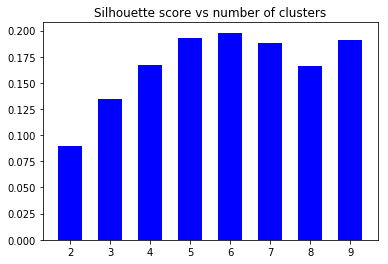

In [45]:
# Plot the clusters with the silhouette scores

plt.figure()
plt.bar(range_values, scores, width=0.6, color='blue', align='center')
plt.title('Silhouette score vs number of clusters')


In [46]:
# Get the average silhouette score at 6 cluster

n_clusters = 6
silhouette_avg = -1
while silhouette_avg <0.1975:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
        
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 6 The average silhouette_score is : 0.1975212714826081


In [47]:
# View the size of the clusters six clusters

pd.Series(clusters).value_counts().sort_index()


0    989
1    650
2     97
3    613
4    586
5    943
dtype: int64

For n_clusters = 2 The average silhouette_score is : 0.0897635923533955
For n_clusters = 3 The average silhouette_score is : 0.1267431004061146
For n_clusters = 4 The average silhouette_score is : 0.16693095894115667
For n_clusters = 5 The average silhouette_score is : 0.1722455113254745


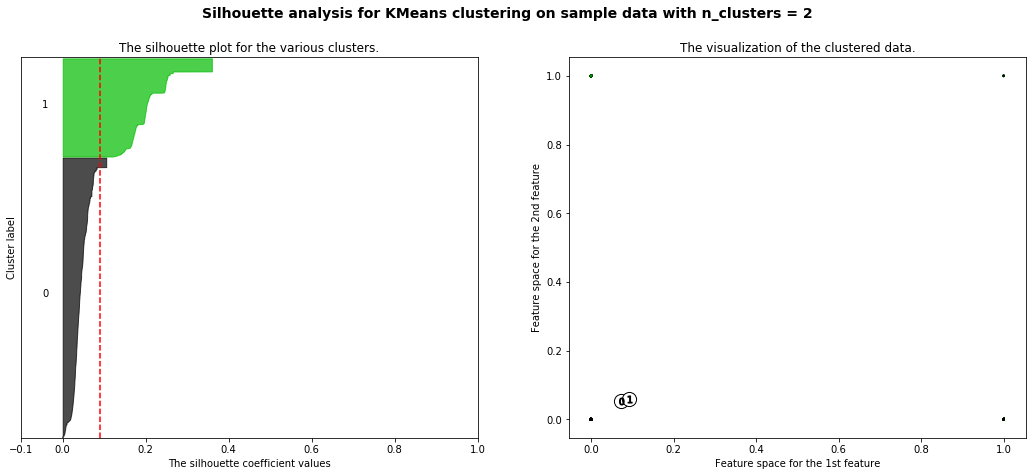

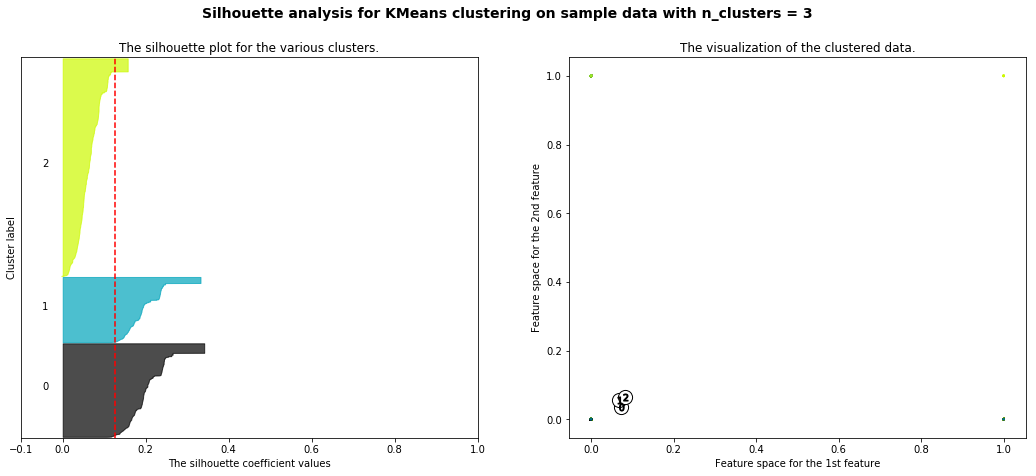

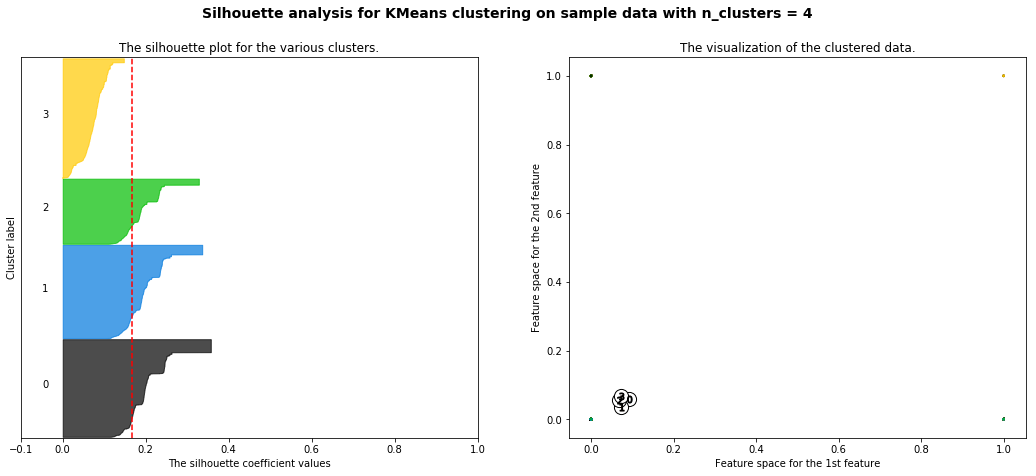

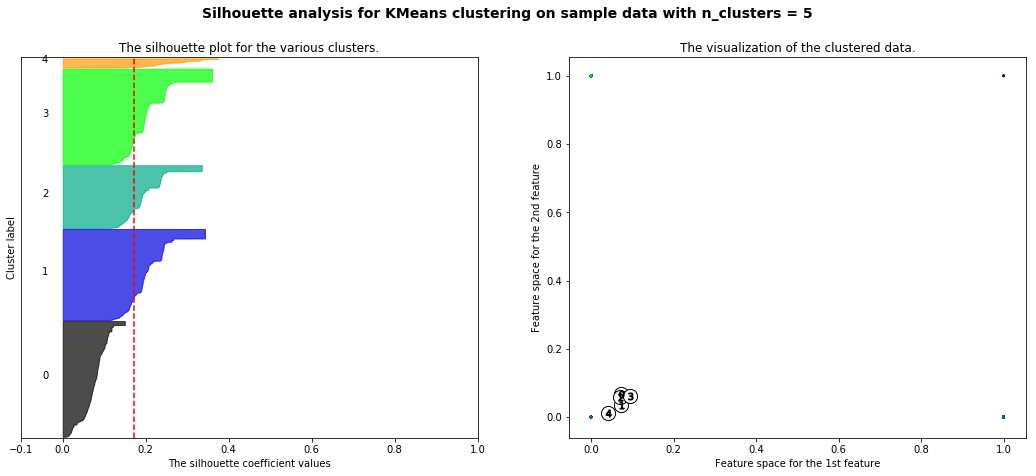

In [48]:
## Used silhouette code from 
## https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(matrix) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(matrix)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(matrix, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(matrix, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(matrix[:, 0], matrix[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [49]:
## DATA MUNGING

In [50]:
## CREATE CUSTOMER CATEGORIES

In [54]:
# Add product category field to the clean data frame

categ_val = dict()

#combine the plist_products df with the cluster number using zip function
for key, val in zip(plist_words,clusters):
    categ_val[key] = val

#add prod_categ to the clean df
df_mkdataclean['prod_categ'] = df_mkdataclean.loc[:, 'Description'].map(categ_val)

#show that the product category was added to the df
df_mkdataclean[['Description','prod_categ']][:10]

,Description,prod_categ
0,WHITE HANGING HEART T-LIGHT HOLDER,1
1,WHITE METAL LANTERN,4
2,CREAM CUPID HEARTS COAT HANGER,4
3,KNITTED UNION FLAG HOT WATER BOTTLE,4
4,RED WOOLLY HOTTIE WHITE HEART.,4
5,SET 7 BABUSHKA NESTING BOXES,3
6,GLASS STAR FROSTED T-LIGHT HOLDER,4
7,HAND WARMER UNION JACK,1
8,HAND WARMER RED POLKA DOT,0
9,ASSORTED COLOUR BIRD ORNAMENT,0


In [56]:
# Add the sum of the product categories to the clean dataframe 

for i in range(6):
    #get the approprate prod category
    column = 'prod_cat_{}'.format(i)
    
    df_categdt = df_mkdataclean[df_mkdataclean['prod_categ'] == i]
    
    #get the total price for the invoice
    t_price = df_categdt['TotalPrice']
    
    #populate price in matching column or put a 0 in column
    t_price = t_price.apply(lambda x:x if x > 0 else 0)
    df_mkdataclean.loc[:,column] = t_price
    
    #zero fill missing data
    df_mkdataclean[column].fillna(0, inplace = True)

df_mkdataclean[['Description','prod_categ','prod_cat_0','prod_cat_1','prod_cat_2','prod_cat_3','prod_cat_4','prod_cat_5']][:10]


,Description,prod_categ,prod_cat_0,prod_cat_1,prod_cat_2,prod_cat_3,prod_cat_4,prod_cat_5
0,WHITE HANGING HEART T-LIGHT HOLDER,1,0.00,15.3,0.0,0.0,0.00,0.0
1,WHITE METAL LANTERN,4,0.00,0.0,0.0,0.0,20.34,0.0
2,CREAM CUPID HEARTS COAT HANGER,4,0.00,0.0,0.0,0.0,22.00,0.0
3,KNITTED UNION FLAG HOT WATER BOTTLE,4,0.00,0.0,0.0,0.0,20.34,0.0
4,RED WOOLLY HOTTIE WHITE HEART.,4,0.00,0.0,0.0,0.0,20.34,0.0
5,SET 7 BABUSHKA NESTING BOXES,3,0.00,0.0,0.0,15.3,0.00,0.0
6,GLASS STAR FROSTED T-LIGHT HOLDER,4,0.00,0.0,0.0,0.0,25.50,0.0
7,HAND WARMER UNION JACK,1,0.00,11.1,0.0,0.0,0.00,0.0
8,HAND WARMER RED POLKA DOT,0,11.10,0.0,0.0,0.0,0.00,0.0
9,ASSORTED COLOUR BIRD ORNAMENT,0,54.08,0.0,0.0,0.0,0.00,0.0


In [57]:
# Produce a df with the sum of invoice prices by customerid and invoiceno 
tip = df_mkdataclean.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
tot_inv_price = tip.rename(columns = {'TotalPrice':'Total Invoice Price'})

# Process through the product categories to sum by CustomeId and InvoiceNo
for i in range(6):
    cols = 'prod_cat_{}'.format(i) 
    sum_col = df_mkdataclean.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[cols].sum()
    tot_inv_price.loc[:, cols] = sum_col

# Create another date field as int64 in order to average up the total price
df_mkdataclean['InvoiceDate_int64'] = df_mkdataclean['InvoiceDate'].astype('int64')

invdt_mean = df_mkdataclean.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int64'].mean()

# Add the InvoiceDate back to datetime format
df_mkdataclean['InvoiceDate_dt']=pd.to_datetime(df_mkdataclean['InvoiceDate_int64'])

# Drop fields no longer needed
df_mkdataclean.drop('InvoiceDate_int64', axis = 1, inplace = True)


In [58]:
# Remove the negative transactions from the summarized data frame
tot_inv_price = tot_inv_price[tot_inv_price['Total Invoice Price'] > 0]

tot_inv_price.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,Total Invoice Price,prod_cat_0,prod_cat_1,prod_cat_2,prod_cat_3,prod_cat_4,prod_cat_5
1,12347,537626,711.79,187.2,83.40,22.5,124.44,270.85,23.40
2,12347,542237,475.39,118.0,35.40,47.9,38.25,151.50,84.34
3,12347,549222,636.25,330.9,35.70,35.4,38.25,115.00,81.00
4,12347,556201,382.52,74.4,78.06,0.0,19.90,168.76,41.40
5,12347,562032,584.91,109.7,119.70,0.0,136.05,158.16,61.30


In [59]:
# Add summary statistics for each record (min, max, mean, count and sum)

tran_summary=tot_inv_price.groupby(by=['CustomerID'])['Total Invoice Price'].agg(['count','min',
                                                                                   'max','mean','sum'])
# Add the summary statistics to the appropriate product category
for i in range(6):
    col = 'prod_cat_{}'.format(i)
    tran_summary.loc[:,col] = tot_inv_price.groupby(by=['CustomerID'])[col].sum() /\
                                            tran_summary['sum']*100

tran_summary.reset_index(drop = False, inplace = True)

# Sum the data up by Customer Id
tot_inv_price.groupby(by=['CustomerID'])['prod_cat_0'].sum()
tot_inv_price

# Sort the transactions by CustomerID
tran_summary.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,prod_cat_0,prod_cat_1,prod_cat_2,prod_cat_3,prod_cat_4,prod_cat_5
0,12347,7,224.82,1294.32,615.714286,4310.00,26.085847,19.573086,2.454756,12.041531,28.607657,11.237123
1,12348,4,227.44,892.80,449.310000,1797.24,41.953217,0.000000,2.323563,20.030714,0.000000,35.692506
2,12349,1,1757.55,1757.55,1757.550000,1757.55,24.765156,9.497312,13.467611,42.189411,7.308469,2.772041
3,12350,1,334.40,334.40,334.400000,334.40,48.444976,27.900718,6.100478,11.961722,0.000000,5.592105
4,12352,7,144.35,840.30,340.815714,2385.71,15.705178,4.071325,0.622456,64.322571,13.979067,1.299404


In [60]:
# Create a matrix with scaled features that are imporant to keep for modeling

imp_features = ['count','min','max','mean','prod_cat_0','prod_cat_1','prod_cat_2','prod_cat_3','prod_cat_4', 'prod_cat_5']


customers = tran_summary.copy(deep = True)
s_matrix = customers[imp_features].values

## standaridize the features
scaler = StandardScaler()
scaler.fit(s_matrix)
scaled_matrix = scaler.transform(s_matrix)

In [61]:
# Produce a silhouette score to see how well the clusters are separated

client_scores = []
matrix = scaled_matrix
range_values = np.arange(2,15)

for i in range_values:
    kmeans = KMeans(init='k-means++', n_clusters = i, n_init=30)
    kmeans.fit(matrix)
    client_clusters = kmeans.predict(matrix)
    
    #define score for each datapoint (score=(x-y)/max(x/y))
    #x is the avg distance between current data point and all other datapoints in the same cluster
    #y is the avg distance between the current data point and all the datapoints in the next cluster
    score = metrics.silhouette_score(matrix, kmeans.labels_, metric='euclidean', sample_size = len(matrix))
    print ("Number of Clusters = ", i, "the silhouette score = ", score)
    scores.append(score)

Number of Clusters =  2 the silhouette score =  0.6783968621069316
Number of Clusters =  3 the silhouette score =  0.13590418452672173
Number of Clusters =  4 the silhouette score =  0.13118499161476724
Number of Clusters =  5 the silhouette score =  0.14416480317731262
Number of Clusters =  6 the silhouette score =  0.14979709669256974
Number of Clusters =  7 the silhouette score =  0.1592210401889845
Number of Clusters =  8 the silhouette score =  0.17392931138956785
Number of Clusters =  9 the silhouette score =  0.18421377252979912
Number of Clusters =  10 the silhouette score =  0.19228241460478035
Number of Clusters =  11 the silhouette score =  0.19384310986808714
Number of Clusters =  12 the silhouette score =  0.19638084648510823
Number of Clusters =  13 the silhouette score =  0.16226910573977416
Number of Clusters =  14 the silhouette score =  0.19850103940641348


For n_clusters = 7 The average silhouette_score is : 0.15866653316529994
For n_clusters = 8 The average silhouette_score is : 0.1646121901978438
For n_clusters = 9 The average silhouette_score is : 0.18155404534590777
For n_clusters = 10 The average silhouette_score is : 0.1942172590838588
For n_clusters = 11 The average silhouette_score is : 0.19549849183942244


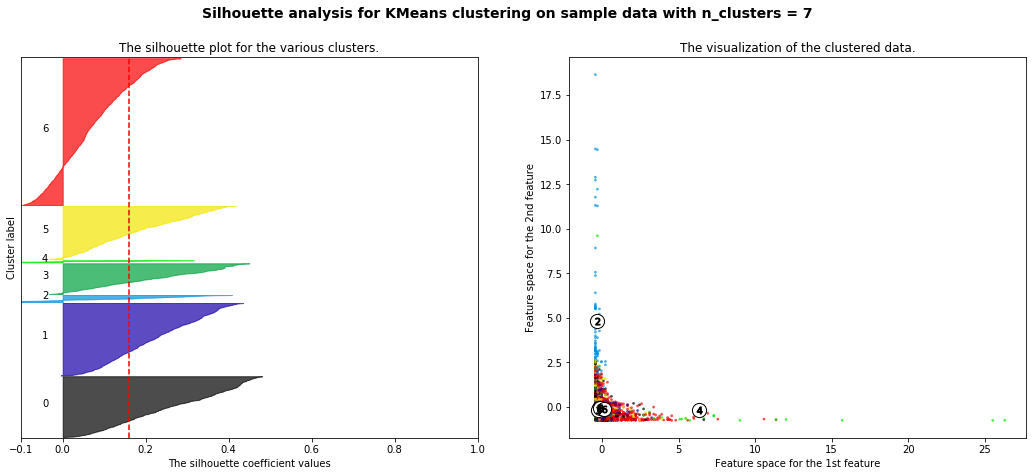

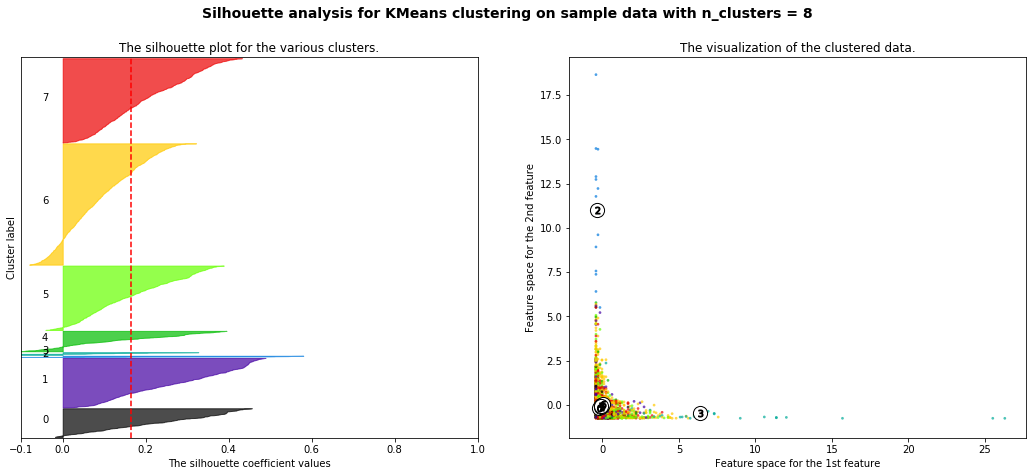

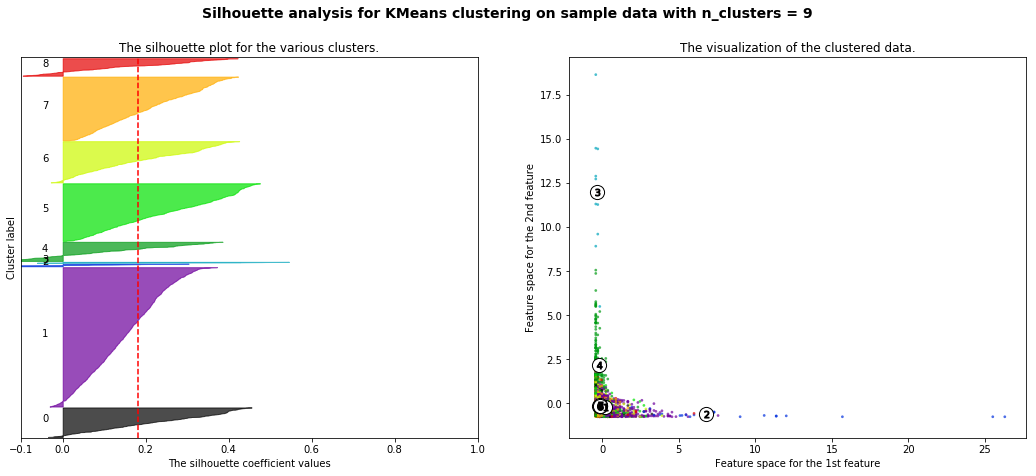

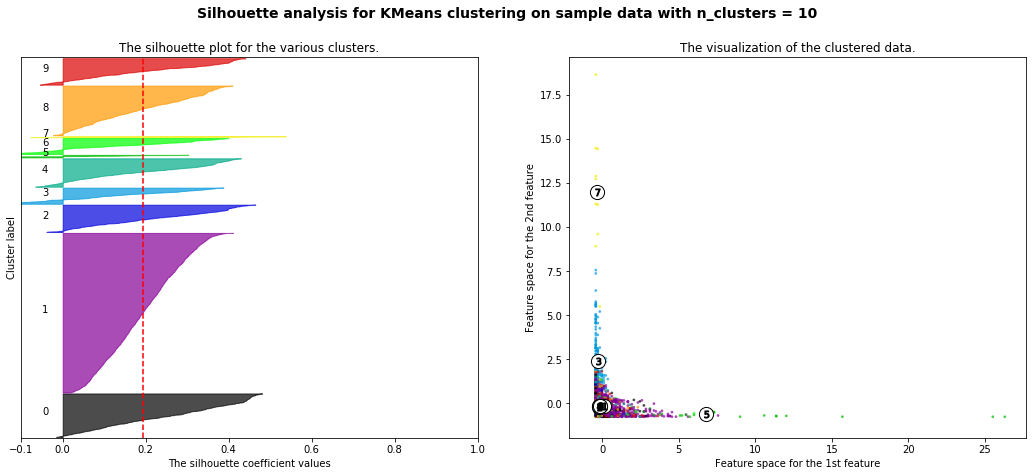

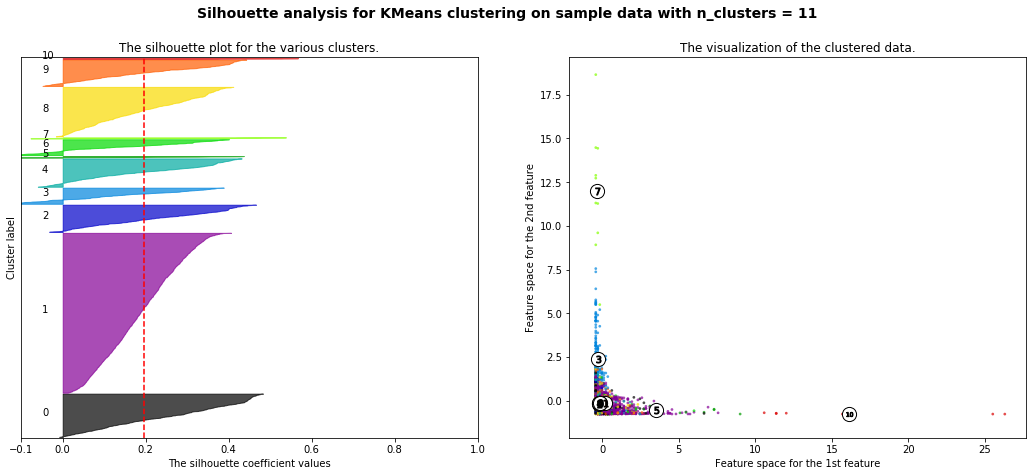

In [62]:
# Used silhouette code from 
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

scale_range_n_clusters = [7, 8, 9, 10, 11]

for n_clusters in scale_range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(matrix) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(matrix)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(matrix, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(matrix, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(matrix[:, 0], matrix[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [64]:
# Get the average silhouette score at 11 clusters
n_clusters = 11
silhouette_avg = -1
while silhouette_avg <0.1925:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(matrix)
    client_clusters = kmeans.predict(scaled_matrix)
    silhouette_avg = silhouette_score(scaled_matrix, client_clusters)
    
   
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 11 The average silhouette_score is : 0.19309485030298504


In [66]:
# Add a cluster field to use for indexing

customers.loc[:, 'cluster'] = client_clusters

customers.head()

,CustomerID,count,min,max,mean,sum,prod_cat_0,prod_cat_1,prod_cat_2,prod_cat_3,prod_cat_4,prod_cat_5,cluster
0,12347,7,224.82,1294.32,615.714286,4310.00,26.085847,19.573086,2.454756,12.041531,28.607657,11.237123,1
1,12348,4,227.44,892.80,449.310000,1797.24,41.953217,0.000000,2.323563,20.030714,0.000000,35.692506,10
2,12349,1,1757.55,1757.55,1757.550000,1757.55,24.765156,9.497312,13.467611,42.189411,7.308469,2.772041,3
3,12350,1,334.40,334.40,334.400000,334.40,48.444976,27.900718,6.100478,11.961722,0.000000,5.592105,5
4,12352,7,144.35,840.30,340.815714,2385.71,15.705178,4.071325,0.622456,64.322571,13.979067,1.299404,7


In [67]:
# Create a final dataframe of summary statistics for each cluster to be used for modeling

cluster_summary = pd.DataFrame()

for i in range(n_clusters):
    temp = pd.DataFrame(customers[customers['cluster'] == i].mean())
   
    #set the index to the cluster number
    temp = temp.T.set_index('cluster',drop = True)
    
    #add the size of each cluster
    temp['size'] = customers[customers['cluster'] == i].shape[0]
   
    #merge the two dataframes
    cluster_summary = pd.concat([cluster_summary, temp])
    
cluster_summary.drop('CustomerID', axis = 1, inplace = True)

cluster_summary = cluster_summary.sort_values('sum')
cluster_summary

,count,min,max,mean,sum,prod_cat_0,prod_cat_1,prod_cat_2,prod_cat_3,prod_cat_4,prod_cat_5,size
cluster,,,,,,,,,,,,
10.0,2.347826,187.358043,318.610186,242.064541,623.426894,19.901050,11.638953,3.278412,8.247272,6.807785,50.126528,322
5.0,2.711806,203.976094,347.400399,270.869795,759.991373,53.705553,13.087124,3.711281,8.836592,7.981582,12.681067,576
8.0,2.853107,206.851921,344.918136,274.079391,834.784576,16.521042,11.873309,37.955827,13.670068,8.547200,11.432554,177
7.0,3.012579,199.352078,355.099119,263.961706,842.859352,10.483742,9.910727,2.968808,62.438257,9.672253,4.526215,477
6.0,2.690852,197.775363,370.373060,269.937708,931.430978,13.322043,12.005081,3.141535,14.105485,50.610492,6.841462,317
0.0,3.396947,196.376336,404.457455,291.026564,1085.821679,15.855214,53.388639,4.789030,9.802436,8.583417,7.581263,393
1.0,5.236972,194.570906,568.260878,350.733062,1926.569046,24.204402,20.488294,5.773198,20.759355,16.839349,11.940122,1823
3.0,2.467005,982.187970,1622.936503,1266.608604,3447.413406,24.189765,19.603333,7.508383,21.563782,16.495297,10.639780,197
9.0,1.500000,4075.741667,6245.503333,5073.737778,7931.028333,16.495757,22.690436,9.002749,22.025976,12.152787,17.632295,12


In [68]:
## MODELING SECTION

In [69]:
# Create the final data to model with the desired features

features = ['mean', 'prod_cat_0', 'prod_cat_1', 'prod_cat_2', 'prod_cat_3', 'prod_cat_4', 'prod_cat_5' ]

# Independent variables/features
X = customers[features]

# Dependent variable
Y = customers['cluster']


In [70]:
# Split the data into train and test
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state=0)

In [207]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', Y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', Y_test.shape)

Training Features Shape: (3461, 7)
Training Labels Shape: (3461,)
Testing Features Shape: (866, 7)
Testing Labels Shape: (866,)


In [ ]:
# Functions defined for later use

In [71]:
# Confusion Matrix function
# Retrieved from....https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
## Build the models (Support Vector Machine, Logistic Regression, Decision Tree and K Nearest Neighbor)

In [ ]:
## Support Vector Machine Model

In [73]:
svclassifier = SVC(kernel='linear')  
svclassifier.fit(X_train, Y_train)  

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [74]:
# Predicting the test set results and calculating the accuracy
y_pred = svclassifier.predict(X_test)  

print("Accuracy of support vector machine test set ", accuracy_score(Y_test,y_pred)*100)

Accuracy of support vector machine test set  94.45727482678984


Confusion matrix, without normalization


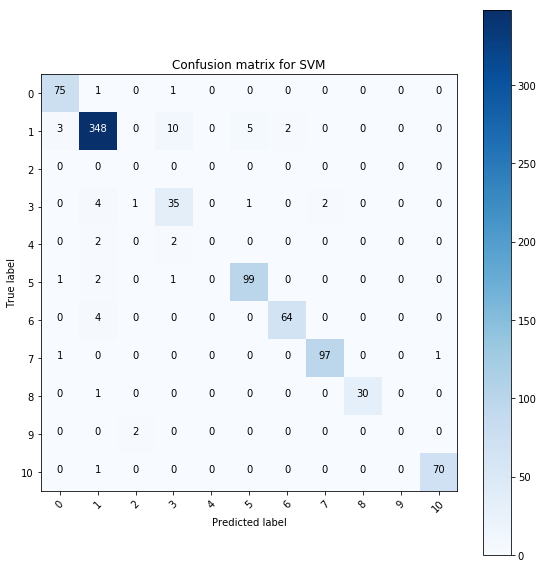

In [75]:
# Compute confusion matrix, using function defined above
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, y_pred)

np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix for SVM')

In [76]:
# Produce classification report
class_names = [i for i in range(11)]
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96        77
           1       0.96      0.95      0.95       368
           2       0.00      0.00      0.00         0
           3       0.71      0.81      0.76        43
           4       0.00      0.00      0.00         4
           5       0.94      0.96      0.95       103
           6       0.97      0.94      0.96        68
           7       0.98      0.98      0.98        99
           8       1.00      0.97      0.98        31
           9       0.00      0.00      0.00         2
          10       0.99      0.99      0.99        71

   micro avg       0.94      0.94      0.94       866
   macro avg       0.68      0.69      0.68       866
weighted avg       0.94      0.94      0.94       866



C:\Users\donna\Anaconda3\envs\MarketSegmentation\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\donna\Anaconda3\envs\MarketSegmentation\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\donna\Anaconda3\envs\MarketSegmentation\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\donna\Anaconda3\envs\MarketSegmentation\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labe

In [77]:
# Logistic Regression Model

In [78]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [79]:
# Predicting the test set results and calculating the accuracy
y_pred = logreg.predict(X_test)

print("Accuracy of logistic regression classifier on test set ", accuracy_score(Y_test,y_pred)*100)

Accuracy of logistic regression classifier on test set  89.4919168591224


Confusion matrix, without normalization


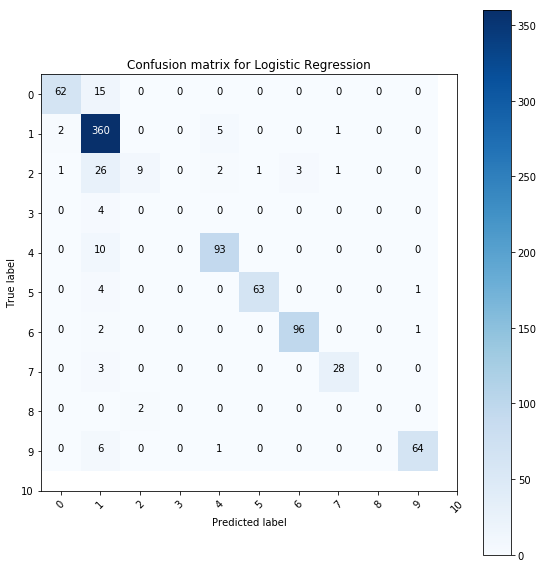

In [80]:
# Compute confusion matrix, using function defined above
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, y_pred)

np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix for Logistic Regression')

In [81]:
# Produce classification report
class_names = [i for i in range(11)]
print(classification_report(Y_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.81      0.87        77
           1       0.84      0.98      0.90       368
           3       0.82      0.21      0.33        43
           4       0.00      0.00      0.00         4
           5       0.92      0.90      0.91       103
           6       0.98      0.93      0.95        68
           7       0.97      0.97      0.97        99
           8       0.93      0.90      0.92        31
           9       0.00      0.00      0.00         2
          10       0.97      0.90      0.93        71

   micro avg       0.89      0.89      0.89       866
   macro avg       0.74      0.66      0.68       866
weighted avg       0.89      0.89      0.88       866



C:\Users\donna\Anaconda3\envs\MarketSegmentation\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\donna\Anaconda3\envs\MarketSegmentation\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\donna\Anaconda3\envs\MarketSegmentation\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [82]:
# Decision Tree Model

In [83]:
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=5)
clf_gini.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [84]:
# Predicting the test set results and calculating the accuracy
y_pred = clf_gini.predict(X_test)
print("Accuracy of decision tree on test set ", accuracy_score(Y_test,y_pred)*100)

Accuracy of decision tree on test set  72.63279445727483


In [85]:
# Produce classification report
class_names = [i for i in range(11)]
print(classification_report(Y_test, y_pred))


              precision    recall  f1-score   support

           0       0.90      0.92      0.91        77
           1       0.64      0.97      0.77       368
           3       0.78      0.16      0.27        43
           4       0.00      0.00      0.00         4
           5       0.84      0.89      0.87       103
           6       0.00      0.00      0.00        68
           7       0.97      0.98      0.97        99
           8       0.00      0.00      0.00        31
           9       0.00      0.00      0.00         2
          10       0.67      0.06      0.10        71

   micro avg       0.73      0.73      0.73       866
   macro avg       0.48      0.40      0.39       866
weighted avg       0.65      0.73      0.64       866



C:\Users\donna\Anaconda3\envs\MarketSegmentation\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\donna\Anaconda3\envs\MarketSegmentation\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\donna\Anaconda3\envs\MarketSegmentation\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [86]:
# K Nearest Neighbor

In [87]:
knn = neighbors.KNeighborsClassifier()
knn.fit(X_train, Y_train)
knn_pred = knn.predict(X_test)

print("Accuracy of k-nearest neighbor", accuracy_score(Y_test,knn_pred)*100)

Accuracy of k-nearest neighbor 81.87066974595842


In [88]:
# Produce classification report
class_names = [i for i in range(11)]
print(classification_report(Y_test, knn_pred))


              precision    recall  f1-score   support

           0       0.90      0.73      0.81        77
           1       0.75      0.93      0.83       368
           2       0.00      0.00      0.00         0
           3       0.68      0.84      0.75        43
           4       0.00      0.00      0.00         4
           5       0.90      0.72      0.80       103
           6       1.00      0.71      0.83        68
           7       0.98      0.85      0.91        99
           8       1.00      0.55      0.71        31
           9       1.00      0.50      0.67         2
          10       0.91      0.69      0.78        71

   micro avg       0.82      0.82      0.82       866
   macro avg       0.74      0.59      0.64       866
weighted avg       0.84      0.82      0.82       866



C:\Users\donna\Anaconda3\envs\MarketSegmentation\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\donna\Anaconda3\envs\MarketSegmentation\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\donna\Anaconda3\envs\MarketSegmentation\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\donna\Anaconda3\envs\MarketSegmentation\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labe